# Pokemon Classifier
Using PyTorch, this notebook describes an approach of designing a model capable of classifying pokemon. 

This is based on training on a self-created dataset.

## Setup

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiplicativeLR
from torchvision import transforms, utils, models
from PIL import Image

Clone the corresponding git repo to access the dataset:

In [ ]:
# !git clone https://github.com/thomasbohm/pokemon-classifier.git
# %cd pokemon-classifier/

In [ ]:
# !unzip -q data.zip

Another option (faster for development) is to download the `data.zip` file from [here](https://github.com/thomasbohm/pokemon-classifier) and store it in your private google drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/MyDrive/pokemon-classifier/data.zip -d .

### Exploring the Dataset

In the `annotations.csv` file there are all images mapped to corresponding pokemon ids which will represent the ground truth of the samples. Official pokemon ids are **1-index based** which needs to be considered later on.

In [4]:
annotation_df = pd.read_csv('./data/annotations.csv')
annotation_df.head()

,img_path,pokemon_id
0,abra001.jpg,63
1,abra002.jpg,63
2,abra003.jpg,63
3,abra004.jpg,63
4,abra005.jpg,63


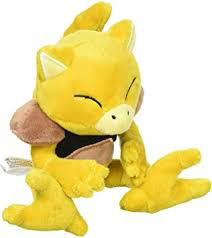

In [5]:
Image.open('./data/images/abra002.jpg')

To get an overview of how well all pokemon classes are represented, # images per classes are plotted and the mean of # images per class is computed.

Total # images: 8554
Avg. # images per class: 56.6



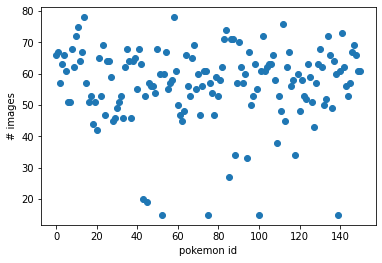

In [6]:
counts_per_class = annotation_df.groupby('pokemon_id').count()
counts_np = counts_per_class.iloc[:,0].to_numpy()

print(f'Total # images: {annotation_df.shape[0]}')
print(f'Avg. # images per class: {counts_np.mean():.1f}\n')

fig, ax = plt.subplots()
ax.set_xlabel('pokemon id')
ax.set_ylabel('# images')
ax.scatter(list(range(151)), counts_np)
fig.show()

In [7]:
os.chdir('./data/images')

img_sizes_x, img_sizes_y = [], []
big_images = 0
for i in os.listdir():
    img_size = Image.open(i).size
    img_sizes_x.append(img_size[0])
    img_sizes_y.append(img_size[1])
    
    if img_size[0] >= 300 or img_size[1] >= 300:
        big_images += 1
        
os.chdir('../..')

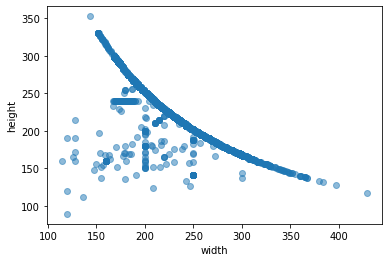

In [8]:
fig, ax = plt.subplots()
ax.scatter(img_sizes_x, img_sizes_y, alpha=0.5)
ax.set_xlabel('width')
ax.set_ylabel('height')
fig.show()

In [9]:
print(f'# big images / # all images: {big_images / len(img_sizes_x):.2f}')

# big images / # all images: 0.17


Since most models provided by torchvision.models require images of at least 224x224 and most of the dataset's images are below 300px, a fixed size of 256x256 seems to be reasonable.

## Preparing the Dataset & Dataloaders

The labels are stored at initialization while images are loaded into memory at runtime. Initially, the dataset contained some RGBA images (four channels) thus it is important to convert all images to the same format, RGB. 

One sample will be:
1. sized 3x256x256
2. casted to a tensor in range [0, 1]
3. normalized using recommended values

One label will be decremented by one to be 0-index based.

In [10]:
class PokemonDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        label = self.img_labels.iloc[idx, 1]
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [11]:
dataset = PokemonDataset('./data/annotations.csv',
                         './data/images',
                         transform=transforms.Compose([transforms.Resize((256, 256)), 
                                                       transforms.ToTensor(),
                                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                            std=[0.229, 0.224, 0.225])]),
                         target_transform=lambda x: x-1)

The data will be split into subsets and fed into seperate dataloaders:
 - Train set (70%)
 - Val set (15%)
 - Test set (15%)


In [12]:
train_set_size = int(len(dataset) * 0.7)
val_set_size = int(len(dataset) * 0.15)
test_set_size = len(dataset) - train_set_size - val_set_size

train_set, val_set, test_set = random_split(dataset, (train_set_size, val_set_size, test_set_size))

len(dataset), len(train_set), len(val_set), len(test_set)

(8554, 5987, 1283, 1284)

In [13]:
dataloaders = {
    'train': DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True),
    'val': DataLoader(val_set, batch_size=2*64, shuffle=False, pin_memory=True),
    'test': DataLoader(test_set, batch_size=2*64, shuffle=False, pin_memory=True)
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


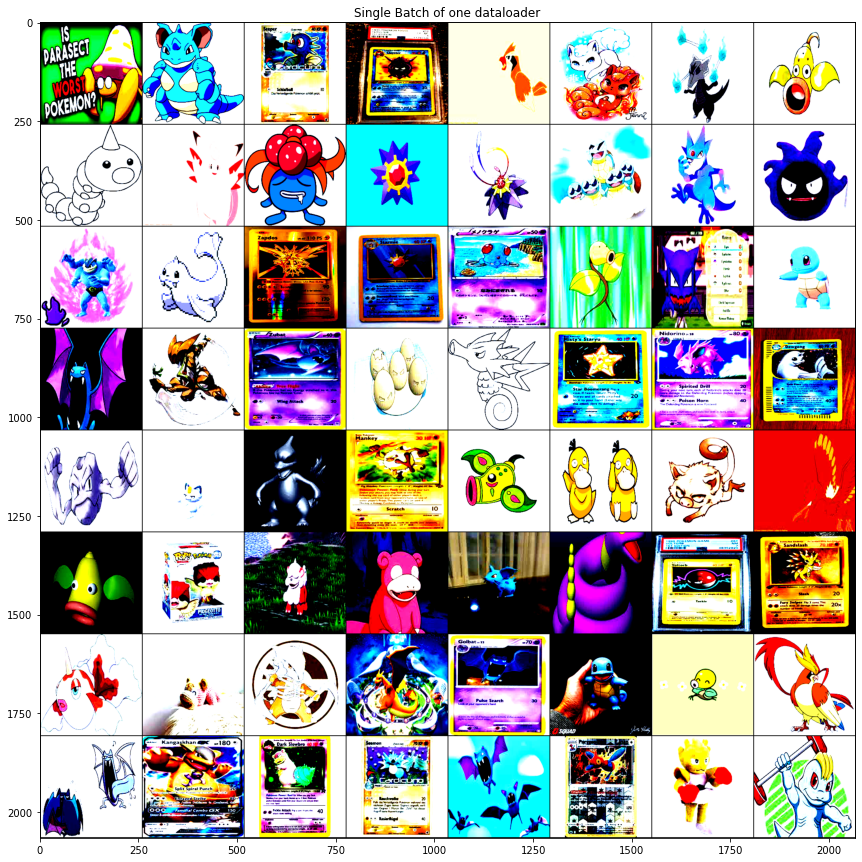

In [14]:
def show_batch(sample_batched):
    images_batch, label_batch = sample_batched
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    fig, ax = plt.subplots(figsize=(20,15))
    ax.set_title('Single Batch of one dataloader')
    ax.imshow(grid.numpy().transpose((1, 2, 0)))

for batch in dataloaders['train']:
    show_batch(batch)
    break

## Training the Model

In [15]:
def train(model, device, dataloader, criterion, optimizer):
    model.train()
    for xb, yb in dataloader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        model.zero_grad()
        loss.backward()
        optimizer.step()


def test(model, device, dataloader, criterion):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss += criterion(logits, yb)

            _, predicted = logits.max(1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()

        avg_loss = loss / len(dataloader)
        accuracy = 100 * correct / total

    return avg_loss, accuracy


def fit(model, device, dataloaders, criterion, optimizer, num_epochs, scheduler=None):
    best_loss = None
    best_state_dict = None

    for epoch in range(num_epochs):
        start_time = time.time()
        # Train
        train(model, device, dataloaders['train'], criterion, optimizer)
        # Evaluate
        avg_loss, accuracy = test(model, device, dataloaders['val'], criterion)
        # Save the best
        if not best_loss or avg_loss < best_loss:
            best_loss = avg_loss
            best_state_dict = model.state_dict()
        if scheduler:
            scheduler.step()

        print(f'Epoch: {epoch+1:02}/{num_epochs:02} | Val. loss: {avg_loss:.3f} | Val. accuracy: {accuracy:.3f}% | Time needed: {time.time() - start_time:.2f}s')
    
    torch.save(best_state_dict, '/content/best.pt')
    torch.save(model.state_dict(), '/content/last.pt')
    print('\nTraining done. Saved "best.pt" and "last.pt".')

Choosen are the following building blocks:
- model: torchvisions implementation of MobileNet V3 Large
- criterion: cross entropy loss
- optimizer: Adam with initial lr of 0.001 and reduction factor 0.9 after every epoch


In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device:', device)

#model = nn.Sequential(nn.Flatten(), nn.Linear(3*256*256, 151))
#model = models.mobilenet_v3_small(pretrained=True).to(device)
model = models.mobilenet_v3_large(pretrained=True, progress=False).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.9)

Device: cuda


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


In [17]:
fit(model, device, dataloaders, criterion, optimizer, num_epochs=25, scheduler=scheduler)

Epoch: 01/25 | Val. loss: 3.075 | Val. accuracy: 37.490% | Time needed: 81.75s
Epoch: 02/25 | Val. loss: 1.469 | Val. accuracy: 61.341% | Time needed: 81.78s
Epoch: 03/25 | Val. loss: 1.185 | Val. accuracy: 71.161% | Time needed: 82.12s
Epoch: 04/25 | Val. loss: 0.850 | Val. accuracy: 78.254% | Time needed: 81.88s
Epoch: 05/25 | Val. loss: 0.792 | Val. accuracy: 80.436% | Time needed: 84.37s
Epoch: 06/25 | Val. loss: 0.812 | Val. accuracy: 80.748% | Time needed: 81.90s
Epoch: 07/25 | Val. loss: 0.709 | Val. accuracy: 83.398% | Time needed: 82.28s
Epoch: 08/25 | Val. loss: 0.717 | Val. accuracy: 82.073% | Time needed: 81.67s
Epoch: 09/25 | Val. loss: 0.682 | Val. accuracy: 84.022% | Time needed: 81.94s
Epoch: 10/25 | Val. loss: 0.653 | Val. accuracy: 83.710% | Time needed: 82.12s
Epoch: 11/25 | Val. loss: 0.642 | Val. accuracy: 83.710% | Time needed: 82.46s
Epoch: 12/25 | Val. loss: 0.618 | Val. accuracy: 84.645% | Time needed: 82.31s
Epoch: 13/25 | Val. loss: 0.610 | Val. accuracy: 84.

## Testing the Model

In [18]:
model.load_state_dict(torch.load('best.pt'))

test_loss, test_accuracy = test(model, device, dataloaders['test'], criterion)
print(f'TEST loss: {test_loss:.3f} | TEST accuracy: {test_accuracy:.3f}%')

TEST loss: 0.654 | TEST accuracy: 84.969%


The model achieves an accuracy of **84.97%** on the test dataset. Concerns are discussed in the ReadMe under ***Results & Limitations***

Although no hyperparameter tuning was performed and training time could have been longer, the result should be sufficient to be embedded in a simple test application. 
Check out my project [Pokemon Webapp](https://github.com/thomasbohm/pokemon-webapp) to see the model in action!